In [125]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [126]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [129]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

In [130]:

tree_image_id = os.listdir('images/tree')[0]
tree_image = load_image(os.path.join('images/tree',tree_image_id))
print(f'shape: {tree_image.shape}')
print(f'type: {type(tree_image)}')
model.predict(tree_image)
people_id = os.listdir('images/people')[0]
people_image = load_image(os.path.join('images/people',people_id))
model.predict(people_image)





shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[0.09972642, 0.05400022, 0.08427041, ..., 1.9023477 , 1.7298015 ,
        0.10537978]], dtype=float32)

In [131]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: tree or people
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x)

In [132]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [133]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [134]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 614 images belonging to 2 classes.
Found 68 images belonging to 2 classes.


In [135]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
19/19 [==============================] - 26s 1s/step - loss: 0.3432 - val_loss: 0.0884
Epoch 2/10
19/19 [==============================] - 23s 1s/step - loss: 0.0682 - val_loss: 0.0314
Epoch 3/10
19/19 [==============================] - 22s 1s/step - loss: 0.0384 - val_loss: 0.0289
Epoch 4/10
19/19 [==============================] - 22s 1s/step - loss: 0.0190 - val_loss: 0.0183
Epoch 5/10
19/19 [==============================] - 21s 1s/step - loss: 0.0142 - val_loss: 0.0328
Epoch 6/10
19/19 [==============================] - 21s 1s/step - loss: 0.0157 - val_loss: 0.0123
Epoch 7/10
19/19 [==============================] - 22s 1s/step - loss: 0.0125 - val_loss: 0.0630
Epoch 8/10
19/19 [==============================] - 22s 1s/step - loss: 0.0120 - val_loss: 0.0348
Epoch 9/10
19/19 [==============================] - 21s 1s/step - loss: 0.0090 - val_loss: 0.0161
Epoch 10/10
19/19 [==============================] - 22s 1s/step - loss: 0.0076 - val_loss: 0.0114


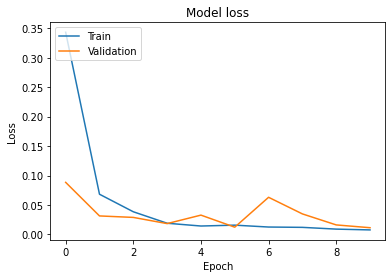

In [136]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [257]:
random_people = random.choice(os.listdir('images/people/'))
people_path = os.path.join('images/people',random_people)
people = load_image(people_path)

random_tree = random.choice(os.listdir('images/tree/'))
tree_path = os.path.join('images/tree',random_tree)
tree = load_image(tree_path)

treeman = load_image('treeman.jpg')


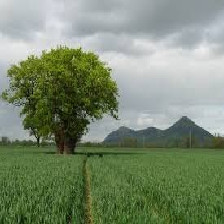

In [264]:
tf.keras.preprocessing.image.load_img(tree_path, target_size=(224,224))

In [275]:
print(f'''[people,tree]:{np.round(model.predict(tree),2)}''')

[people,tree]:[[0. 1.]]


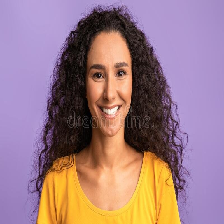

In [276]:
tf.keras.preprocessing.image.load_img(people_path, target_size=(224,224))

In [277]:
print(f'''[people,tree]:{np.round(model.predict(people),2)}''')

[people,tree]:[[1. 0.]]


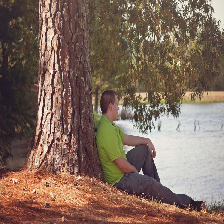

In [278]:
tf.keras.preprocessing.image.load_img('treeman.jpg',target_size=(224,224))

In [279]:
print(f'''[people,tree]:{np.round(model.predict(treeman),2)}''')

[people,tree]:[[0.93 0.07]]
